In [1]:
import os
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import yfinance as yf
from LSTM import SimpleLSTM

In [2]:
# Reproducibility: cố định seed để kết quả lặp lại
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#Cau hinh
CSV_PATH = "GOOGL_2y.csv"
SEQ_LEN = 60 # Window length (60 ngay) dùng 60 ngày trước để dự đoán ngày kế tiếp
BATCH_SIZE = 32
HIDDEN_SIZE = 64
NUM_LAYERS = 2
LR = 0.001
EPOCHS = 200
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ",DEVICE)

Device:  cpu


In [3]:
if not os.path.exists(CSV_PATH):
    print("Không tìm thấy file sạch. Tải dữ liệu GOOGL 2 năm từ yfinance...")
    df_raw = yf.download("GOOGL", period="2y", progress=False)
    # Lưu file gốc tạm
    df_raw.to_csv("GOOGL_2y_raw.csv")
    # Chuẩn hóa tên cột: đảm bảo có Open, High, Low, Close, Volume
    df = df_raw.copy()
    df.to_csv(CSV_PATH)
    print("Đã tải và lưu:", CSV_PATH)
else:
    df = pd.read_csv(CSV_PATH, index_col="Date", parse_dates=True)
    print("Đã đọc file:", CSV_PATH)

print("Dữ liệu tổng:", df.shape)
print(df.head())

Đã đọc file: GOOGL_2y.csv
Dữ liệu tổng: (502, 5)
                 Close        High         Low        Open    Volume
Date                                                                
2023-11-13  131.185211  131.681786  130.350969  130.877337  18324800
2023-11-14  132.704727  134.770481  132.406794  133.270830  32395200
2023-11-15  133.697876  134.105071  132.655080  133.946164  23861500
2023-11-16  135.992050  136.280072  133.399943  134.263979  28013200
2023-11-17  134.383133  135.127995  132.734500  135.068409  37240600


In [4]:
# Lấy 5 cột features
features = ['Close', 'High', 'Low', 'Open', 'Volume'] # <--- THAY ĐỔI
features_df = df[features].copy() # <--- THAY ĐỔI

# Cutoff index theo ti le 70/15/15 tren time series
n_total = len(features_df) # <--- THAY ĐỔI
#Tao sequences, tong samples = n_total - SEQ_LEN
n_samples = n_total - SEQ_LEN
train_samples = int(n_samples*0.70)
val_samples = int(n_samples * 0.15)
test_samples = n_samples - train_samples - val_samples

print(f"Total days: {n_total}, sequence samples: {n_samples}")
print(f"Train samples: {train_samples}, Val samples: {val_samples}, Test samples: {test_samples}")

# --- Fit scaler CHỈ trên phần train (tránh data leakage) ---
train_raw_end = SEQ_LEN + train_samples #exclusive index for raw array slicing
print("train_raw end index (exclusive): ", train_raw_end)      

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features_df.values[:train_raw_end]) # <--- THAY ĐỔI: Fit trên 5 features
scaled_all = scaler.transform(features_df.values) # <--- THAY ĐỔI: Transform 5 features

# tao sequences (sliding window)
X_list, y_list = [], []
for i in range(SEQ_LEN, len(scaled_all)):
    X_list.append(scaled_all[i-SEQ_LEN:i, :]) # <--- THAY ĐỔI: Lấy cửa sổ (60, 5) cho X
    y_list.append(scaled_all[i, 0]) # <--- THAY ĐỔI: Lấy feature 'Close' (cột 0) cho y

X = np.array(X_list)
y = np.array(y_list)

#reshape X -> (n_samples, seq_len, n_features)
# X = X.reshape(X.shape[0], X.shape[1],1) # <--- THAY ĐỔI: Không cần reshape, X đã có shape (n_samples, seq_len, 5)

print("X shape:", X.shape, "y shape:", y.shape)

# fit scaler = học các thông số để scale dữ liệu từ dataset train, để dữ liệu đưa vào mô hình có cùng thang đo, giúp mô hình học ổn định và tránh rò rỉ thông tin.

Total days: 502, sequence samples: 442
Train samples: 309, Val samples: 66, Test samples: 67
train_raw end index (exclusive):  369
X shape: (442, 60, 5) y shape: (442,)


In [5]:
sample_cut_train = train_samples
sample_cut_val = train_samples + val_samples

X_train = X[:sample_cut_train]
y_train =y[:sample_cut_train]

X_val = X[sample_cut_train:sample_cut_val]
y_val = y[sample_cut_train:sample_cut_val]

X_test = X[sample_cut_val:]
y_test = y[sample_cut_val:]

print("Final splits:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:  ", X_val.shape, "y_val:", y_val.shape)
print("  X_test: ", X_test.shape, "y_test:", y_test.shape)

Final splits:
  X_train: (309, 60, 5) y_train: (309,)
  X_val:   (66, 60, 5) y_val: (66,)
  X_test:  (67, 60, 5) y_test: (67,)


In [6]:
# Chuyển sang tensor và tạo DataLoader

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(DEVICE)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created. Batch size:", BATCH_SIZE)

DataLoaders created. Batch size: 32


In [8]:
from LSTM import SimpleLSTM

model = SimpleLSTM(input_size=5, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1).to(DEVICE) # <--- THAY ĐỔI

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    running_train_loss = 0.0
    for Xb, yb in train_loader:
        batch_size = Xb.size(0)
        hidden = model.init_hidden(batch_size, DEVICE)

        optimizer.zero_grad()
        preds, _ = model(Xb, hidden)  # preds shape (batch, 1)
        preds = preds.squeeze(1)      # shape (batch,)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0) # prevent exploding grad
        optimizer.step()

        running_train_loss += loss.item() * batch_size
    
    avg_train_loss = running_train_loss / len(train_ds)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            batch_size = Xb.size(0)
            hidden = model.init_hidden(batch_size, DEVICE)
            preds, _ = model(Xb, hidden)
            preds = preds.squeeze(1)
            loss = criterion(preds, yb)
            running_val_loss += loss.item() * batch_size
    avg_val_loss = running_val_loss / len(val_ds)
    val_losses.append(avg_val_loss)

    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "best_simplelstm_goog.pth")

    print(f"Epoch {epoch}/{EPOCHS} — Train MSE: {avg_train_loss:.6f} | Val MSE: {avg_val_loss:.6f}")

print("Training finished. Best val loss:", best_val_loss, "at epoch", best_epoch)

Epoch 1/200 — Train MSE: 0.271340 | Val MSE: 0.134716
Epoch 2/200 — Train MSE: 0.054052 | Val MSE: 0.012378
Epoch 3/200 — Train MSE: 0.029756 | Val MSE: 0.042431
Epoch 4/200 — Train MSE: 0.019421 | Val MSE: 0.008888
Epoch 5/200 — Train MSE: 0.015237 | Val MSE: 0.016408
Epoch 6/200 — Train MSE: 0.010442 | Val MSE: 0.004502
Epoch 7/200 — Train MSE: 0.007208 | Val MSE: 0.010756
Epoch 8/200 — Train MSE: 0.006536 | Val MSE: 0.007132
Epoch 9/200 — Train MSE: 0.005811 | Val MSE: 0.004119
Epoch 10/200 — Train MSE: 0.005477 | Val MSE: 0.006666
Epoch 11/200 — Train MSE: 0.005401 | Val MSE: 0.007813
Epoch 12/200 — Train MSE: 0.005161 | Val MSE: 0.004967
Epoch 13/200 — Train MSE: 0.004987 | Val MSE: 0.004225
Epoch 14/200 — Train MSE: 0.004715 | Val MSE: 0.005314
Epoch 15/200 — Train MSE: 0.004717 | Val MSE: 0.007686
Epoch 16/200 — Train MSE: 0.004807 | Val MSE: 0.004571
Epoch 17/200 — Train MSE: 0.004466 | Val MSE: 0.004070
Epoch 18/200 — Train MSE: 0.004329 | Val MSE: 0.004020
Epoch 19/200 — Trai

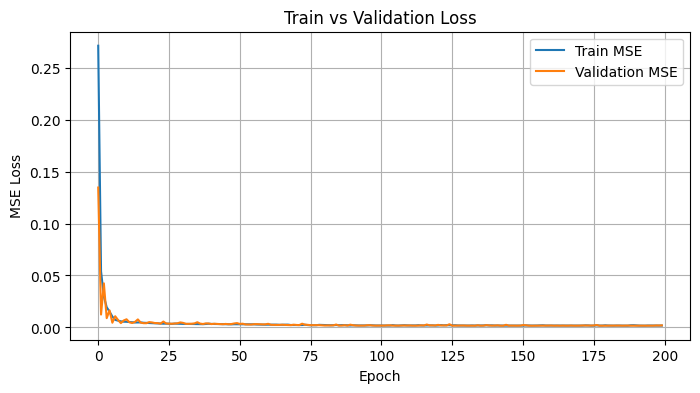

In [10]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Cell 9 - Load best model và đánh giá trên tập test -> compute MAE & RMSE
model.load_state_dict(torch.load("best_simplelstm_goog.pth"))
model.eval()

preds_all = []
trues_all = []

with torch.no_grad():
    for Xb, yb in test_loader:
        batch_size = Xb.size(0)
        hidden = model.init_hidden(batch_size, DEVICE)
        preds, _ = model(Xb, hidden)
        preds_all.append(preds.squeeze(1).cpu().numpy())
        trues_all.append(yb.cpu().numpy())

preds_all = np.concatenate(preds_all, axis=0).reshape(-1, 1)  # scaled
trues_all = np.concatenate(trues_all, axis=0).reshape(-1, 1)  # scaled

# Inverse transform to price scale
# <--- THAY ĐỔI: Cần tạo mảng 5-feature-dummy để inverse_transform
# Tạo mảng dummy (n_samples, 5) cho dự đoán
preds_dummy = np.zeros((len(preds_all), 5))
preds_dummy[:, 0] = preds_all.flatten() # Đặt dự đoán 'Close' vào cột đầu tiên
preds_price = scaler.inverse_transform(preds_dummy)[:, 0] # Inverse transform và chỉ lấy cột 'Close'

# Tạo mảng dummy (n_samples, 5) cho giá trị thật
trues_dummy = np.zeros((len(trues_all), 5))
trues_dummy[:, 0] = trues_all.flatten() # Đặt giá trị 'Close' thật vào cột đầu tiên
trues_price = scaler.inverse_transform(trues_dummy)[:, 0] # Inverse transform và chỉ lấy cột 'Close'
# <--- KẾT THÚC THAY ĐỔI

mae = mean_absolute_error(trues_price, preds_price) # Mức chênh lệch trung bình giữa dự đoán và giá thật
mse = mean_squared_error(trues_price, preds_price)  # Phạt sai số lớn mạnh hơn, đo độ ổn định của mô hình
rmse = np.sqrt(mse) # RMSE = √MSE → nên ta tự lấy căn.
r2 = r2_score(trues_price, preds_price)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R2 score: {r2:.4f}")

Test MAE: 6.7720
Test RMSE: 8.8356
Test MSE: 78.0683
Test R2 score: 0.8834


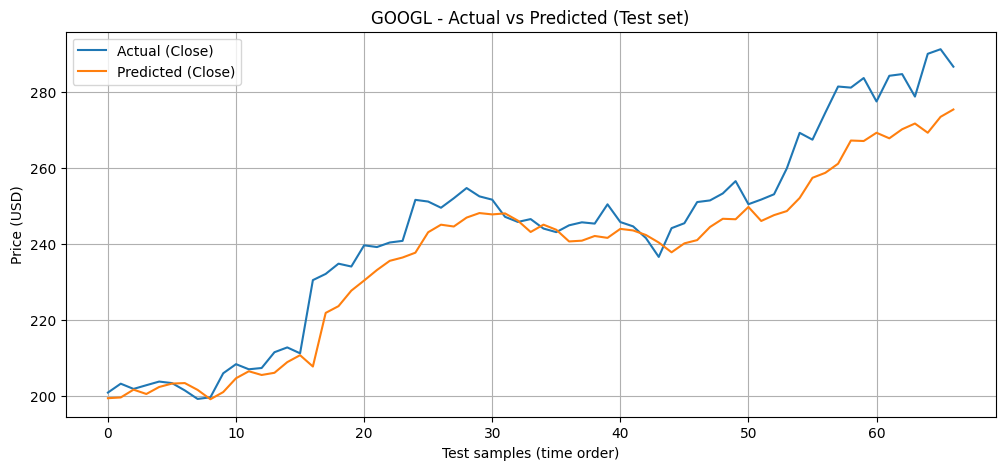

In [13]:
# Plot predictions vs actual (test set)
plt.figure(figsize=(12,5))
plt.plot(trues_price, label="Actual (Close)")
plt.plot(preds_price, label="Predicted (Close)")
plt.xlabel("Test samples (time order)")
plt.ylabel("Price (USD)")
plt.title("GOOGL - Actual vs Predicted (Test set)")
plt.legend()
plt.grid(True)
plt.show()

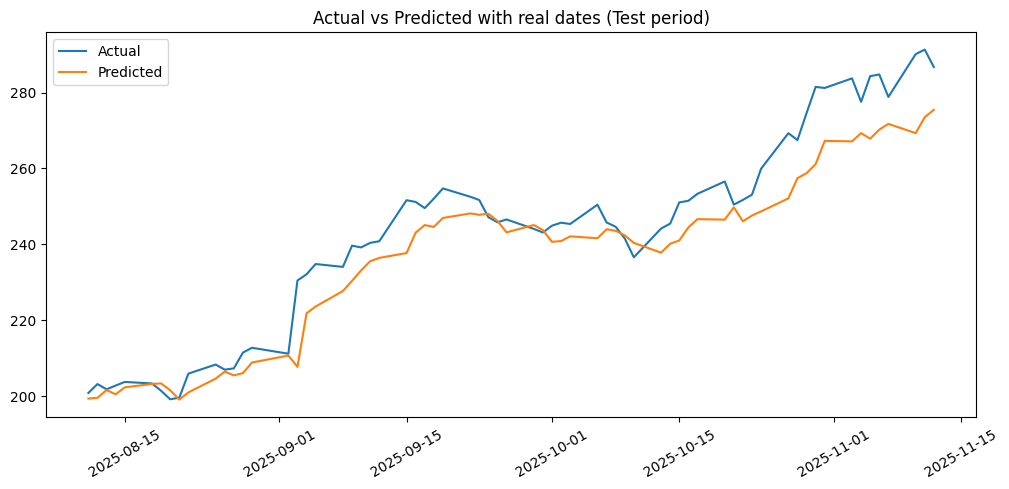

In [14]:
# Optional: map test samples back to original dates for clearer plot
# Khi tạo sequences, sample i corresponds to raw day index i+SEQ_LEN
dates = df.index[SEQ_LEN:]  # <--- THAY ĐỔI: Dùng df index (thay vì close.index)
test_dates = dates[sample_cut_train + val_samples : sample_cut_train + val_samples + len(trues_price)]
# Nếu lengths khớp, ta có thể dùng test_dates as x-axis
plt.figure(figsize=(12,5))
plt.plot(test_dates, trues_price.flatten(), label="Actual")
plt.plot(test_dates, preds_price.flatten(), label="Predicted")
plt.xticks(rotation=30)
plt.legend()
plt.title("Actual vs Predicted with real dates (Test period)")
plt.show()